# MNIST Evaluation

## Common functions

In [1]:
import numpy as np
from sklearn.datasets import load_digits
from tqdm import tqdm
import matplotlib.pyplot as plt

def make_linear_kernel():
    """
    线性核：k(x, y) = x · y^T
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return X.dot(Y.T)
    return kernel

def make_polynomial_kernel(degree: int = 3, gamma: float = None, coef0: float = 1.0):
    """
    多项式核：k(x, y) = (gamma * x·y^T + coef0)^degree
    如果未指定 gamma，则默认 gamma = 1 / dim。
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        nonlocal gamma
        if gamma is None:
            gamma = 1.0 / X.shape[1]
        return (gamma * X.dot(Y.T) + coef0) ** degree
    return kernel

def make_sigmoid_kernel(alpha: float = 0.01, coef0: float = 0.0):
    """
    Sigmoid 核（双曲正切核，也叫神经网络核）：k(x, y) = tanh(alpha * x·y^T + coef0)
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        return np.tanh(alpha * X.dot(Y.T) + coef0)
    return kernel

def make_laplacian_kernel(sigma: float = 1.0):
    """
    拉普拉斯核（基于 L1 距离）：k(x, y) = exp( -||x - y||_1 / sigma )
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        # 计算成对的 L1 距离矩阵
        abs_diff = np.abs(X[:, None, :] - Y[None, :, :])
        dist = np.sum(abs_diff, axis=2)
        return np.exp(-dist / sigma)
    return kernel

# 可选：Matern 核（ν = 3/2 形式示例）
def make_matern32_kernel(length_scale: float = 1.0):
    """
    Matern-3/2 核：k(r) = (1 + sqrt(3) r / l) * exp(-sqrt(3) r / l)
    其中 r = ||x - y||_2，l = length_scale。
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        # 计算成对的 L2 距离矩阵
        sq_dist = np.sum((X[:, None, :] - Y[None, :, :])**2, axis=2)
        r = np.sqrt(sq_dist)
        factor = np.sqrt(3) * r / length_scale
        return (1 + factor) * np.exp(-factor)
    return kernel

# 1. RBF‐kernel 工厂函数：指定 sigma 后返回一个 kernel(X, Y) 函数
def make_rbf_kernel(sigma: float):
    """
    返回一个 Gaussian RBF kernel 函数，固定带宽 sigma。
    kernel(X, Y) 接受形状为 (n, d) 和 (m, d) 的数组，返回 (n, m) 的相似度矩阵。
    """
    def kernel(X: np.ndarray, Y: np.ndarray) -> np.ndarray:
        # 广播计算平方距离
        # X[:, None, :] 变为 (n,1,d)，Y[None, :, :] 变为 (1,m,d)
        sq_dist = np.sum((X[:, None, :] - Y[None, :, :]) ** 2, axis=2)
        return np.exp(-sq_dist / (2 * sigma ** 2))
    return kernel

MAKE_KERNEL_FACTORIES = {
    'linear': make_linear_kernel,
    'polynomial': make_polynomial_kernel,
    'sigmoid': make_sigmoid_kernel,
    'laplacian': make_laplacian_kernel,
    'matern32': make_matern32_kernel,
    'rbf': make_rbf_kernel
}

# 2. 计算 MMD² 的函数，只需传入 kernel
def compute_mmd(X: np.ndarray, Y: np.ndarray, kernel) -> float:
    """
    计算两个样本 X, Y 之间的 MMD²（无偏估计量）。
    """
    m = X.shape[0]
    n = Y.shape[0]

    K_XX = kernel(X, X)
    K_YY = kernel(Y, Y)
    K_XY = kernel(X, Y)

    mmd2 = (np.sum(K_XX) / (m * m)
            + np.sum(K_YY) / (n * n)
            - 2 * np.sum(K_XY) / (m * n))
    return mmd2


# 3. permutation_test 接受 kernel，自动利用它生成 null 分布
def permutation_test(
    X: np.ndarray,
    Y: np.ndarray,
    kernel,
    num_permutations: int = 500
) -> float:
    """
    对 H0: P=Q 进行置换检验，返回 p-value。
    """
    observed_mmd = compute_mmd(X, Y, kernel)
    combined = np.vstack((X, Y))
    m = X.shape[0]

    permuted_stats = []
    for _ in range(num_permutations):
        idx = np.random.permutation(combined.shape[0])
        Xp = combined[idx[:m]]
        Yp = combined[idx[m:]]
        permuted_stats.append(compute_mmd(Xp, Yp, kernel))
    permuted_stats = np.array(permuted_stats)
    p_value = np.mean(permuted_stats >= observed_mmd)
    return p_value, observed_mmd, permuted_stats



# 4. 通用计算 MNIST 样本对 p 值矩阵
def compute_mnist_matrix(sample_size: int, num_permutations: int, kernel) -> np.ndarray:
    """
    分别从 digits 0-9 中随机抽取 sample_size 样本作为 X 与 Y，计算所有数字对 (i,j) 的 p 值矩阵。
    显示计算进度。
    """
    digits = load_digits()
    X_all, y_all = digits.data, digits.target
    p_mat = np.zeros((10, 10))
    for i in tqdm(range(10), desc=f'Outer loop (digit i)'):
        Xi = X_all[y_all == i]
        for j in tqdm(range(10), desc=f'Inner loop (digit j)', leave=False):
            if i == j:
                idx_all = np.random.choice(len(Xi), sample_size*2, replace=False)
                X = Xi[idx_all[:sample_size]]
                Y = Xi[idx_all[sample_size:]]
            else:
                Xj = X_all[y_all == j]
                idx_i = np.random.choice(len(Xi), sample_size, replace=False)
                idx_j = np.random.choice(len(Xj), sample_size, replace=False)
                X = Xi[idx_i]
                Y = Xj[idx_j]
            p_mat[i, j], observed_mmd, permuted_stats = permutation_test(X, Y, kernel, num_permutations)
    return p_mat


def plot_p_matrix(p_matrix: np.ndarray, title: str = "Permutation Test p-values") -> None:
    """
    绘制 p 值热力图，并在每个格子上标注具体的 p 值。

    参数:
        p_matrix (np.ndarray): shape=(10,10) 的 p 值矩阵
    返回:
        fig, ax: Matplotlib Figure 和 Axes 对象
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(p_matrix, interpolation='nearest', vmin=0, vmax=1)
    # 在每个格子上标注 p 值
    for i in range(p_matrix.shape[0]):
        for j in range(p_matrix.shape[1]):
            val = p_matrix[i, j]
            color = "white" if val < 0.5 else "black"
            ax.text(j, i, f"{val:.2f}", ha="center", va="center", color=color, fontsize=8)
    # 色条
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('p-value')
    # 坐标标签
    ax.set_xticks(np.arange(p_matrix.shape[1]))
    ax.set_yticks(np.arange(p_matrix.shape[0]))
    ax.set_xlabel('Digit Y')
    ax.set_ylabel('Digit X')
    ax.set_title(title)
    plt.tight_layout()
    return fig, ax


## Ablate sigma

Outer loop (digit i): 100%|██████████| 10/10 [00:32<00:00,  3.26s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_0.2, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

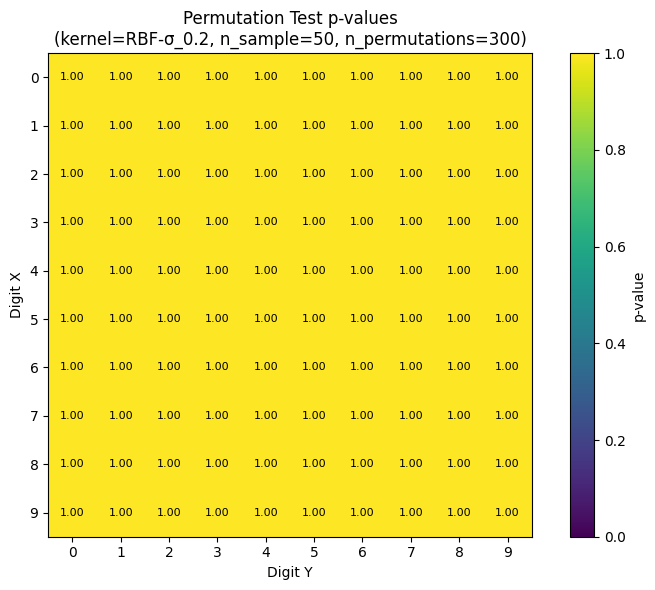

In [11]:
sigma = 0.2
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i): 100%|██████████| 10/10 [00:41<00:00,  4.19s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_1.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

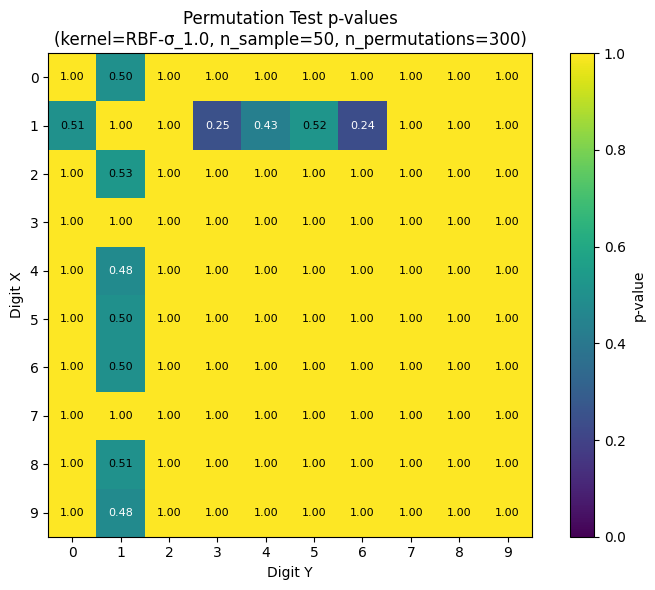

In [10]:
sigma = 1.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i):   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop (digit i): 100%|██████████| 10/10 [00:47<00:00,  4.77s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_2.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

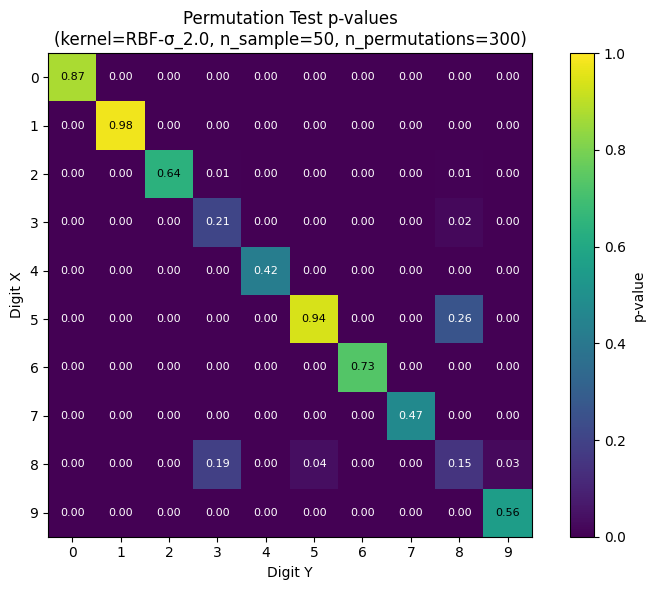

In [18]:
sigma = 2.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i): 100%|██████████| 10/10 [00:25<00:00,  2.59s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_3.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

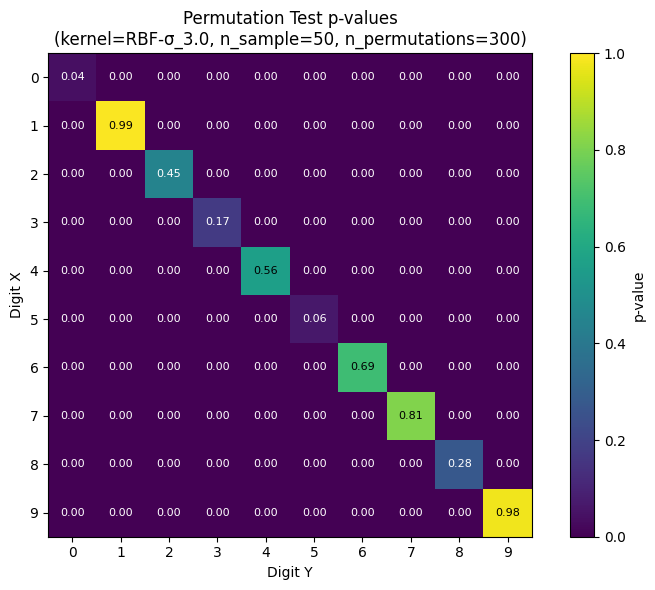

In [9]:
sigma = 3.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i): 100%|██████████| 10/10 [00:27<00:00,  2.79s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_5.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

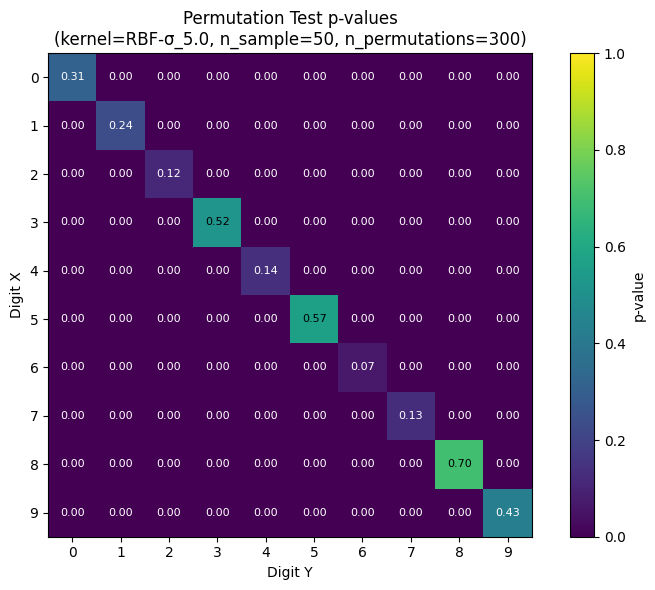

In [ ]:
sigma = 5.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i):   0%|          | 0/10 [00:00<?, ?it/s]


Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.30s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_10.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

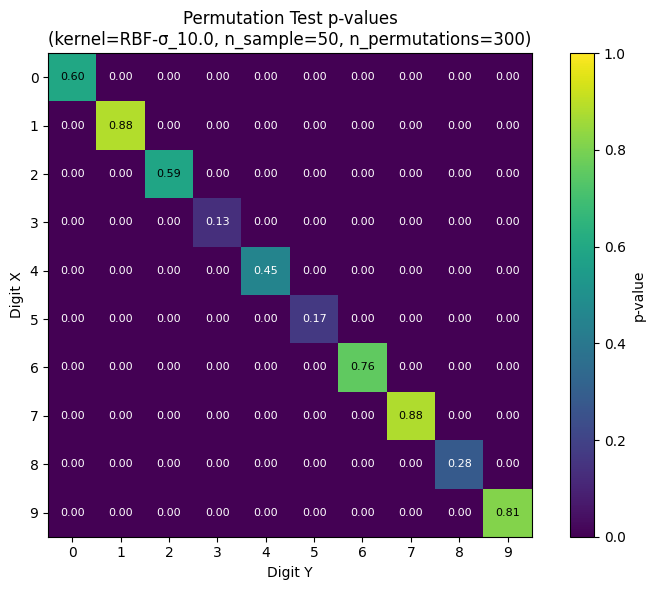

In [15]:
sigma = 10.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_20.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

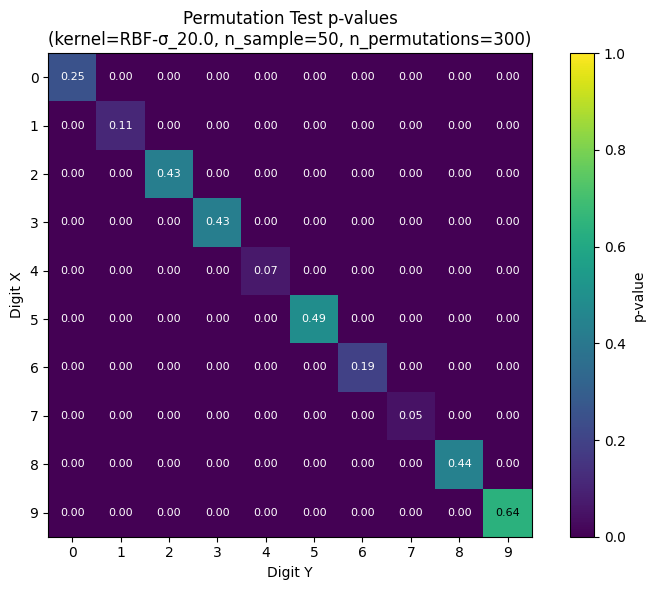

In [17]:
sigma = 20.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i): 100%|██████████| 10/10 [00:33<00:00,  3.36s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_50.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

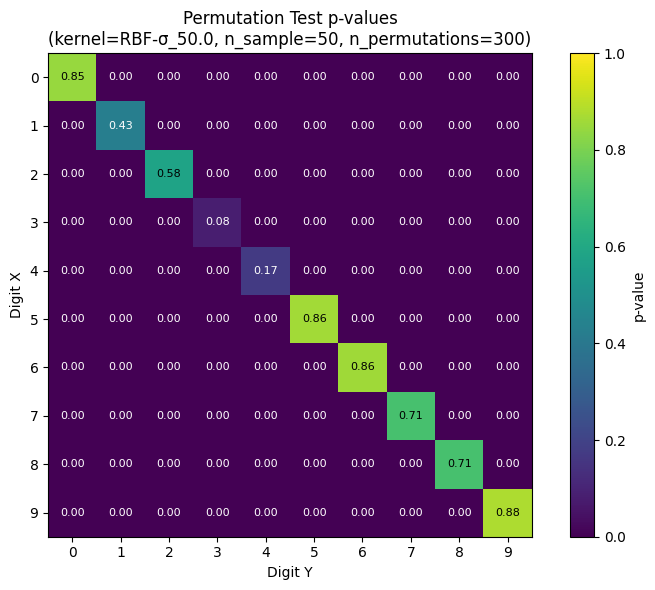

In [16]:
sigma = 50.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

Outer loop (digit i): 100%|██████████| 10/10 [00:34<00:00,  3.48s/it]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_200.0, n_sample=50, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

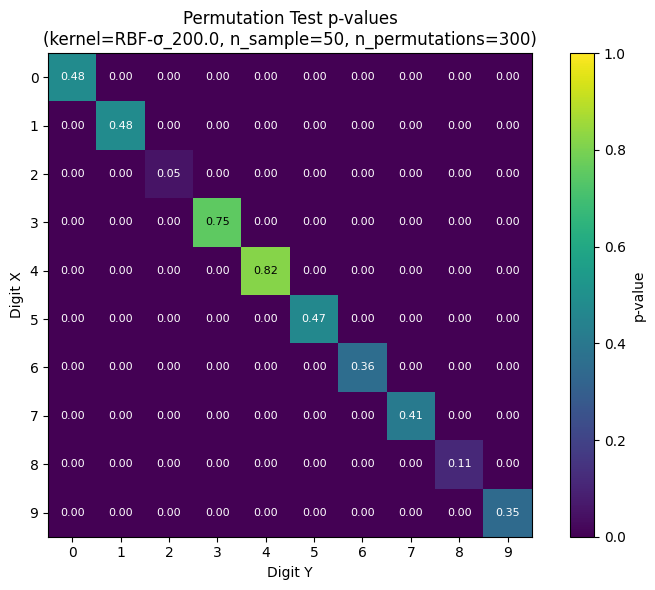

In [19]:
sigma = 200.0
kernel = make_rbf_kernel(sigma)
sample_size = 50
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

## Ablate sample size

Outer loop (digit i):   0%|          | 0/10 [00:00<?, ?it/s]

Outer loop (digit i): 100%|██████████| 10/10 [00:03<00:00,  2.98it/s]


(<Figure size 800x600 with 2 Axes>,
 <AxesSubplot: title={'center': 'Permutation Test p-values\n(kernel=RBF-σ_5.0, n_sample=10, n_permutations=300)'}, xlabel='Digit Y', ylabel='Digit X'>)

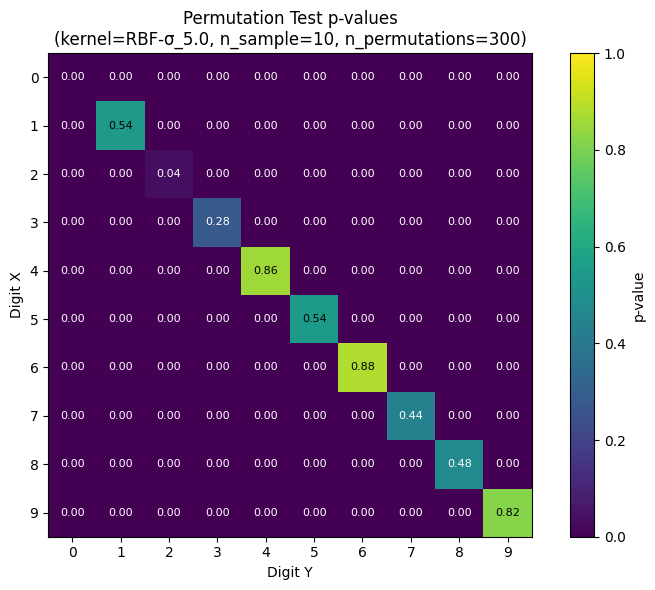

In [ ]:
sigma = 5.0
kernel = make_rbf_kernel(sigma)
sample_size = 10
num_permutations = 300
p_matrix = compute_mnist_matrix(sample_size=sample_size, num_permutations=num_permutations, kernel=kernel)
title = f"Permutation Test p-values\n(kernel=RBF-σ_{sigma}, n_sample={sample_size}, n_permutations={num_permutations})"
plot_p_matrix(p_matrix, title=title)

In [4]:
# 4. 通用计算 MNIST 样本对 p 值矩阵
sample_size = 10
num_permutations = 300
kernel = make_rbf_kernel(sigma)
digits = load_digits()
X_all, y_all = digits.data, digits.target
p_mat = np.zeros((10, 10))

digit_1 = 8
digit_2 = 9
Xi = X_all[y_all == digit_1]
print(f"Digit {digit_1}: {len(Xi)} samples")
Xj = X_all[y_all == digit_2]
print(f"Digit {digit_2}: {len(Xj)} samples")
idx_i = np.random.choice(len(Xi), sample_size, replace=False)
idx_j = np.random.choice(len(Xj), sample_size, replace=False)
X = Xi[idx_i]
Y = Xj[idx_j]
p_value, observed_mmd, permuted_stats = permutation_test(X, Y, kernel, num_permutations)

Digit 8: 174 samples
Digit 9: 180 samples


In [5]:
p_value
observed_mmd
permuted_stats
print(f"p-value: {p_value:.4f}")
print(f"Observed MMD^2: {observed_mmd:.4f}")
for i in range(len(permuted_stats)):
    # 仅打印大于观察到的 MMD^2 的置换统计量
    if permuted_stats[i] > observed_mmd:
        print(f"Permutation {i}: MMD^2 = {permuted_stats[i]:.4f} (greater than observed)")

p-value: 0.0000
Observed MMD^2: 0.2001
